In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from backpack import backpack, extend
from backpack.extensions import DiagHessian
import copy
import pandas as pd
from tqdm import tqdm

torch.cuda.empty_cache()

In [11]:
# Create base images (happy, sad, neutral faces)
def create_base_images():
    base_images = np.zeros((3, 16, 16))
    # Happy face (index 0)
    base_images[0, 4, 4] = base_images[0, 4, 11] = 1  # Eyes
    base_images[0, 10, 5:11] = 1  # Smile (curved upwards)
    base_images[0, 11, 4] = base_images[0, 11, 11] = 1  # Smile curve corners
    base_images[0, 12, 3] = base_images[0, 12, 12] = 1  # Smile curve corners
    
    # Sad face (index 1)
    base_images[1, 4, 4] = base_images[1, 4, 11] = 1  # Eyes
    base_images[1, 11, 5:11] = 1  # Frown (curved downwards)
    base_images[1, 10, 4] = base_images[1, 10, 11] = 1  # Smile curve corners
    base_images[1, 9, 3] = base_images[1, 9, 12] = 1  # Smile curve corners

    # Neutral face (index 2)
    base_images[2, 4, 4] = base_images[2, 4, 11] = 1  # Eyes
    base_images[2, 10, 4:12] = 1  # Straight line for mouth
    
    return base_images

# Generate noisy dataset
def generate_dataset(base_images, label=-1, num_samples=3000, noise_level=0.2, dev='cpu'):
    images = []
    labels = []
    in_label=label
    for i in range(num_samples):
        if in_label == -1:
            label = np.random.randint(0, 3)
        img = base_images[label] + noise_level * np.random.randn(16, 16)
        img = np.clip(img, 0, 1)  # Keep pixel values between 0 and 1
        images.append(img)
        labels.append(label)
    return torch.tensor(images, dtype=torch.float32, device=dev).unsqueeze(1), torch.tensor(labels, dtype=torch.long,device=dev)

# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 16, 64)
        self.fc2 = nn.Linear(64, 3)  # 3 classes
    
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Compute Hessian
def compute_hessian(model, criterion, data, target):
    model.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    grad_params = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    hessian = []
    for grad in grad_params:
        grad_vector = grad.view(-1)
        row = []
        for g in grad_vector:
            second_derivative = torch.autograd.grad(g, model.parameters(), retain_graph=True)
            row.append(torch.cat([sd.contiguous().view(-1) for sd in second_derivative]))
        hessian.append(torch.stack(row))
    return torch.cat(hessian, dim=0)

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


In [ ]:
# Main execution
device='cuda'

base_images = create_base_images()
n_samples = 3000
images_h, labels_h = generate_dataset(base_images, label=0, num_samples=n_samples//3,dev=device)
images_s, labels_s = generate_dataset(base_images, label=1, num_samples=n_samples//3,dev=device)
images_n, labels_n = generate_dataset(base_images, label=2, num_samples=n_samples//3,dev=device)
train_dataset_h = TensorDataset(images_h, labels_h)
train_dataset_s = TensorDataset(images_s, labels_s)
train_dataset_n = TensorDataset(images_n, labels_n)

train_dataset = train_dataset_h + train_dataset_s + train_dataset_n
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

train_dataset_unp = train_dataset_h + train_dataset_n
train_loader_unp = DataLoader(train_dataset_unp, batch_size=32, shuffle=True)

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(8, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Flatten(),                    # Flatten the 16x16x16 feature map
    nn.Linear(16 * 16 * 16, 64),
    nn.ReLU(),
    nn.Linear(64, 3)                 # 3 classes
)

model = extend(model)

criterion = nn.CrossEntropyLoss()
lossfunc = extend(criterion)
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)
train(model, train_loader, criterion, optimizer, epochs=7)

Epoch [1/7], Loss: 0.0017
Epoch [2/7], Loss: 0.0009
Epoch [3/7], Loss: 0.0002
Epoch [4/7], Loss: 0.0001
Epoch [5/7], Loss: 0.0000
Epoch [6/7], Loss: 0.0000
Epoch [7/7], Loss: 0.0000
Epoch [1/7], Loss: 0.0340
Epoch [2/7], Loss: 0.0023
Epoch [3/7], Loss: 0.0006
Epoch [4/7], Loss: 0.0009
Epoch [5/7], Loss: 0.0001
Epoch [6/7], Loss: 0.0002
Epoch [7/7], Loss: 0.0000


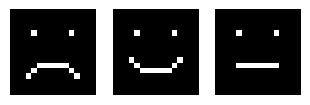

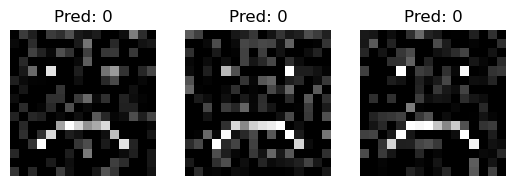

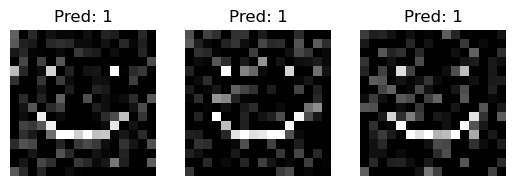

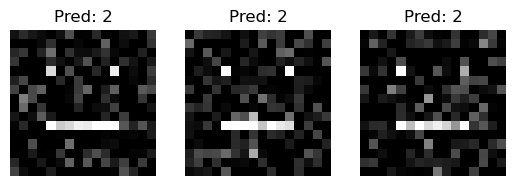

In [13]:

# Test model on some samples
test_samples_h, _ = generate_dataset(base_images, label=0, num_samples=3, dev=device)
test_samples_s, _ = generate_dataset(base_images, label=1, num_samples=3, dev=device)
test_samples_n, _ = generate_dataset(base_images, label=2, num_samples=3, dev=device)
test_samples = torch.cat((test_samples_h, test_samples_s, test_samples_n), dim=0)

with torch.no_grad():
    predictions = model(test_samples).argmax(dim=1)

# Show some test images
for i in range(3):
    plt.subplot(1, 5, i+1)
    plt.imshow(base_images[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

test_samples = test_samples.cpu()
# Show some test images
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[3+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[3+i].item()}')
    plt.axis('off')
plt.show()
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(test_samples[6+i].squeeze(), cmap='gray')
    plt.title(f'Pred: {predictions[6+i].item()}')
    plt.axis('off')
plt.show()


In [14]:
def compute_loss_gradient_after_removal(model, criterion, images, labels, indices_to_remove):
    """
    Compute the gradient of the loss function after removing specific samples.

    Args:
        model: The trained model
        criterion: Loss function
        images: All training images
        labels: All training labels
        indices_to_remove: Indices of samples to exclude from gradient computation

    Returns:
        Gradient norm of the loss function on the reduced dataset
    """
    # Create mask for samples to keep
    mask = torch.ones(len(images), dtype=torch.bool)
    mask[indices_to_remove] = False

    # Get remaining samples
    remaining_images = images[mask]
    remaining_labels = labels[mask]

    # Compute gradient on remaining samples
    model.zero_grad()
    outputs = model(remaining_images)
    loss = criterion(outputs, remaining_labels)
    loss.backward()

    # Calculate gradient norm
    grad_norm = 0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm += torch.norm(param.grad).item()

    return grad_norm, loss.item()

def find_gradient_threshold_for_stability(model, criterion, images_s, labels_s, images_h, labels_h, images_n, labels_n, add=False):
    """
    Study how many poisoned samples can be removed while maintaining a gradient below threshold.

    Args:
        model: The trained model
        criterion: Loss function
        images_s, labels_s: Poisoned samples (sad faces)
        images_h, labels_h: Clean samples (happy faces)
        images_n, labels_n: Clean samples (neutral faces)

    Returns:
        DataFrame with results of the study
    """
    # Combine all datasets for base gradient
    all_images = torch.cat([images_h, images_s, images_n])
    all_labels = torch.cat([labels_h, labels_s, labels_n])

    # Create indices for poisoned samples in the combined dataset
    poison_start_idx = len(images_h)
    poison_end_idx = poison_start_idx + len(images_s)
    poisoned_indices = list(range(poison_start_idx, poison_end_idx))

    print(f"Total samples: {len(all_images)}, Poisoned samples: {len(poisoned_indices)}")

    # Compute influence of each poisoned sample
    print("Computing influence of poisoned samples...")
    poisoned_images = images_s
    poisoned_labels = labels_s

    percentages_to_study = None
    # Study gradient changes as we remove more poisoned samples
    if add:
        percentages_to_study = list(range(100, -1, -1))
    else:
        percentages_to_study = list(range(0, 101, 1))
    results = []
    # Get baseline loss and gradient
    baseline_grad = baseline_loss = 0

    for i, percentage in enumerate(percentages_to_study):

        num_to_remove = int(len(poisoned_indices) * percentage / 100)

        # Compute gradient after removal
        grad_norm, loss = compute_loss_gradient_after_removal(
            model, criterion, all_images, all_labels, poisoned_indices[:num_to_remove])
        
        if i==0:
            # Baseline case - no samples removed
            baseline_grad = grad_norm
            baseline_loss = loss

        results.append({
            'percentage_removed': percentage,
            'num_removed': num_to_remove,
            'gradient_norm': grad_norm,
            'loss': loss,
            'gradient_change': grad_norm - baseline_grad,
            'loss_change': loss - baseline_loss
        })

        print(f"Removed {percentage}% ({num_to_remove}) poisoned samples: "f"Gradient norm = {grad_norm:.4f}, Loss = {loss:.4f}")

    # Convert to DataFrame for easier analysis
    results_df = pd.DataFrame(results)

    # Find the threshold where gradient change becomes significant
    significant_change_threshold = 0.05 * baseline_grad  # 5% of baseline gradient norm
    max_percentage=0
    for result in results:
        if abs(result['gradient_change']) > significant_change_threshold:
            print(f"\nSignificant gradient change detected at {result['percentage_removed']}% removal")
            print(f"This corresponds to removing {result['num_removed']} poisoned samples")
            print(f"Gradient norm increased by {result['gradient_change']:.4f}")
            max_percentage=result['percentage_removed']
            break
    
    return results_df, max_percentage

# Study gradient thresholds
results_df, percetage = find_gradient_threshold_for_stability(
    model, criterion, images_s, labels_s, images_h, labels_h, images_n, labels_n
)

#results_df_unp, percetage_unp = find_gradient_threshold_for_stability(model_unp, criterion_unp, images_s, labels_s, images_h, labels_h, images_n, labels_n, add=True)

Total samples: 3000, Poisoned samples: 1000
Computing influence of poisoned samples...
Removed 0% (0) poisoned samples: Gradient norm = 0.0002, Loss = 0.0000
Removed 1% (10) poisoned samples: Gradient norm = 0.0002, Loss = 0.0000
Removed 2% (20) poisoned samples: Gradient norm = 0.0002, Loss = 0.0000
Removed 3% (30) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 4% (40) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 5% (50) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 6% (60) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 7% (70) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 8% (80) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 9% (90) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 10% (100) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 11% (110) poisoned samples: Gradient norm = 0.0003, Loss = 0.0000
Removed 12% (120) poisoned samples: Gradient n

In [ ]:
def compute_hessians_remove(model, percetage):
    unp_num_samples = int(len(images_s) * (100-percetage) / 100)
    unp_half_num_samples = int(len(images_s) * (100-percetage/2) / 100)

    model.eval()
    train_images=torch.cat([images_h,images_s,images_n])
    train_labels=torch.cat([labels_h,labels_s,labels_n])
    half_images = torch.cat([images_h,images_n,images_s[:unp_half_num_samples]])
    half_labels = torch.cat([labels_h,labels_n,labels_s[:unp_half_num_samples]])
    all_images = torch.cat([images_h,images_n,images_s[:unp_num_samples]])
    all_labels = torch.cat([labels_h,labels_n,labels_s[:unp_num_samples]])

    #Compute the Hessian with poisoned dataset
    loss = lossfunc(model(train_images), train_labels)

    with backpack(DiagHessian()):
        loss.backward(retain_graph=True)
    hessian = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h


    #Compute the Hessian with half poisoned dataset
    loss_half = lossfunc(model(half_images), half_labels)

    with backpack(DiagHessian()):
        loss_half.backward()
    hessian_half = [p.diag_h.clone() for p in model.parameters()]

    for p in model.parameters():
        if hasattr(p, 'diag_h'):
            del p.diag_h

    #Compute the Hessian with unpoisoned dataset
    loss_all = lossfunc(model(all_images), all_labels)

    with backpack(DiagHessian()):
        loss_all.backward()
    hessian_all = [p.diag_h.clone() for p in model.parameters()]

    num_removed = len(train_images) - len(all_images)

    return hessian,hessian_half,hessian_all,num_removed



In [16]:
def compute_der(tensor1, tensor2):
    #Compute first derivative integrals of FI
    ratio = tensor1/tensor2
    return torch.log(ratio)+ 1/2 * (1-torch.pow(ratio,2))

def compute_info(hessian, hessian_half, hessian_unp, num_removed):
    print(f"Removed samples: {num_removed}")

    information = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information):
        #Compute second derivative integrals of FI
        der1 = compute_der(hessian_half[i], hessian[i])
        der2 = compute_der(hessian_unp[i], hessian_half[i])
        information[i]= torch.nan_to_num(der2-der1)/np.power(num_removed//2,2)

    information_quad = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(information_quad):
        ratio = hessian_unp[i]/hessian[i]
        A = torch.log(ratio)
        B = 1/2 * (1-torch.pow(ratio,2))
        information_quad[i]=torch.pow(A,2) + 3/4 * torch.pow(B,2) + A*B
        information_quad[i] = torch.nan_to_num(information_quad[i])/np.power(num_removed,2)

    #Compute relative differences(just for testing and studying)
    delta = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(delta):
        delta[i] = torch.nan_to_num((1/hessian_unp[i]-1/hessian[i])/(1/hessian[i]))

    return information, information_quad, delta

In [17]:
def compute_true_info(hessian, hessian_half, hessian_unp, num_removed):
    information_true = [torch.empty_like(p) for p in hessian]
    A_list = [torch.empty_like(p) for p in hessian]
    B_list = [torch.empty_like(p) for p in hessian]
    for i,_ in enumerate(A_list):
        ratio = torch.where(torch.logical_and(hessian[i]==0, hessian_unp[i]==0), 1, hessian_unp[i]/hessian[i])
        #A=1/2 * torch.log(ratio)/num_removed
        #B=1/2 * (1-torch.pow(ratio,2))/num_removed
        A=1/2 * torch.log(ratio)/num_removed
        B=1/2 * (1-ratio)/num_removed
        A[torch.isinf(A)]=0
        B[torch.isinf(B)]=0
        A_list[i]=torch.nan_to_num(A)
        B_list[i]=torch.nan_to_num(B)

    A_flat = torch.cat([A.flatten() for A in A_list])
    B_flat = torch.cat([B.flatten() for B in B_list])

    torch.cuda.empty_cache()
    device = torch.device("cuda")
    A_flat = A_flat.to(device)
    B_flat = B_flat.to(device)
    information_true = [torch.empty_like(p).to(device) for p in hessian]
    hessian = [p.to(device) for p in hessian]
    hessian_unp = [p.to(device) for p in hessian_unp]

    information_true_view = [p.view(-1) for p in information_true]
    A_list_view = [p.view(-1) for p in A_list]
    B_list_view = [p.view(-1) for p in B_list]
    num_params = sum([p.numel() for p in hessian])
    track=0
    print("\nstart")
    for i,_ in enumerate(information_true_view):
        for j,_ in enumerate(information_true_view[i]):
            if (track+j)%(num_params//10)==0:
                print((track+j)//(num_params//100))

            temp=A_list_view[i][j]*A_flat + B_list_view[i][j]*B_flat + A_list_view[i][j]*B_flat + B_list_view[i][j]*A_flat
            information_true_view[i][j] = torch.sum(temp)+2*torch.pow(B_list_view[i][j],2)
        track+=information_true[i].numel()

    return information_true


In [ ]:
info,info_quad,delt = compute_info(*compute_hessians_remove(model, percetage))

info_true = compute_true_info(*compute_hessians_remove(model, percetage))

Removed samples: 160
Removed samples: 160

start
0
10
20
30
40
50
60
70
80
90
100


True information
91083
Number of outliers: 18218


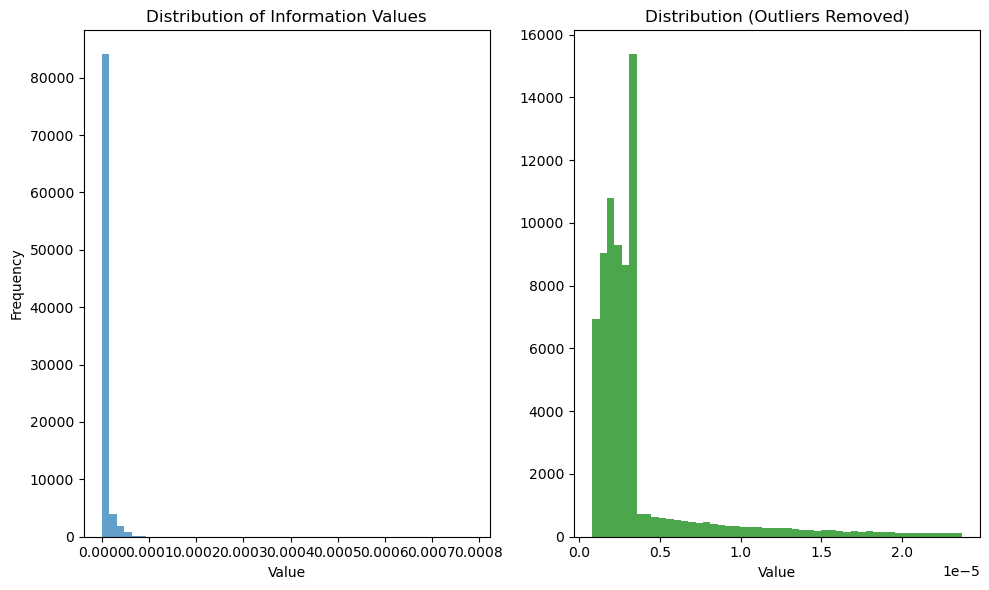

Sum of all information values: 0.463042
Mean: 5.083738869871013e-06
Min: 6.219826628565961e-14
Max: 0.0007837582379579544
Total number of values: 91083
Sum of all information values: 0.272162
Mean: 3.7351583159761503e-06
Min: 8.289254083138076e-07
Max: 2.3671587769058533e-05
Total number of values: 72865


(0.4630421996116638, 0.2721623182296753)

In [ ]:
# 1. Sum all values in the information dictionary
def sum_information_values(information):
    # Initialize an empty list to store all flattened tensors
    all_values = []

    # Iterate through each parameter's information tensor
    for tensor in information:
        # Flatten the tensor and add to our list
        temp=torch.nan_to_num(tensor.flatten())
        temp = temp[torch.isinf(temp)==0]
        temp = temp[temp!=0]
        all_values.append(temp)

    # Concatenate all tensors into one large tensor
    combined_tensor = torch.cat(all_values)
    print(len(combined_tensor))
    return combined_tensor

# 2. Plot the summed information
def plot_information(information):
    combined_tensor = sum_information_values(information)

    # Convert to numpy for plotting
    values = combined_tensor.detach().cpu().numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))

    #Histogram
    plt.subplot(1, 2, 1)
    plt.hist(values, alpha=0.7, bins=50)
    plt.title('Distribution of Information Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Exclude outliers for the second plot (optional)
    q1, q3 = np.percentile(values, [15, 95])
    iqr = q3 - q1
    # lower_bound = q1 - 1.5 * iqr
    # upper_bound = q3 + 1.5 * iqr
    lower_bound = q1
    upper_bound = q3
    filtered_values = values[(values >= lower_bound) & (values <= upper_bound)]
    print(f"Number of outliers: {len(values) - len(filtered_values)}")

    # Filtered histogram (without outliers)
    plt.subplot(1, 2, 2)
    plt.hist(filtered_values, alpha=0.7, bins=50, color='green')
    plt.title('Distribution (Outliers Removed)')
    plt.xlabel('Value')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"Sum of all information values: {combined_tensor.sum().item():.6f}")
    print(f"Mean: {combined_tensor.mean().item()}")
    print(f"Min: {combined_tensor.min().item()}")
    print(f"Max: {combined_tensor.max().item()}")
    print(f"Total number of values: {len(values)}")

    print(f"Sum of all information values: {filtered_values.sum().item():.6f}")
    print(f"Mean: {filtered_values.mean().item()}")
    print(f"Min: {filtered_values.min().item()}")
    print(f"Max: {filtered_values.max().item()}")
    print(f"Total number of values: {len(filtered_values)}")

    return combined_tensor.sum().item(), filtered_values.sum().item()

# Call the plotting function
#plot_information(info)
#print("Delta")
#plot_information(delt)
#print("Quad information")
#plot_information(info_quad)
print("True information")
plot_information(info_true)

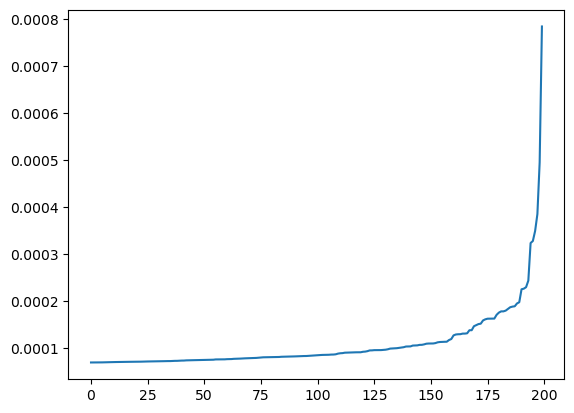

In [24]:
import matplotlib.pyplot as plt
info_true=[p.cpu() for p in info_true]
infocat = torch.cat([p.flatten() for p in info_true])
s_infocat = np.sort(torch.nan_to_num(infocat))
plt.plot(s_infocat[-200:])
plt.show()

# infocat_quad = torch.cat([p.flatten() for p in info])
# s_infocat_quad = np.sort(torch.nan_to_num(infocat_quad))
# plt.plot(s_infocat_quad[-30:])
# plt.show()

# deltacat = torch.cat([p.flatten() for p in delt])
# s_deltacat = np.sort(deltacat)
# plt.plot(s_deltacat)
# plt.show()

In [21]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

In [ ]:
import copy

acc_h = evaluate_accuracy(model, DataLoader(train_dataset_h, batch_size=32, shuffle=False))
acc_s = evaluate_accuracy(model, DataLoader(train_dataset_s, batch_size=32, shuffle=False))
acc_n = evaluate_accuracy(model, DataLoader(train_dataset_n, batch_size=32, shuffle=False))

print(f'Accuracy original model')
print(f'Accuracy on happy faces: {acc_h:.2f}')
print(f'Accuracy on sad faces: {acc_s:.2f}')
print(f'Accuracy on neutral faces: {acc_n:.2f}')
print(f'\n\n')

model_clone = copy.deepcopy(model)
info_analysis = copy.deepcopy(info_true)
info_analysis = [p.to(device) for p in info_analysis]
noise_std = 5
noise_std = torch.tensor(noise_std,device=device)
ts_d=s_infocat[-15]

#Statistical analysis of the impact of the noise on the accuracy
N=100
acc_h_unp_list = np.zeros(N)
acc_s_unp_list = np.zeros(N)
acc_n_unp_list = np.zeros(N)

for j in range(N):

    if j%10==0:
        print(f'Iteration {j}')

    for i,p in enumerate(info_analysis):
        info_analysis[i]=torch.nan_to_num(info_analysis[i])
        #Set a minimum value for the information, below don't add noise
        info_analysis[i]=torch.where(info_analysis[i]>ts_d,1,0)
        #Normalize the information
        # if torch.max(info_analysis[i])>0:
        #     info_analysis[i]=info_analysis[i]/torch.max(info_analysis[i])
        #     #info_analysis[i]=torch.pow(info_analysis[i],2)

    with torch.no_grad():
        for i,param in enumerate(model_clone.parameters()):
            # Add noise weighting on the information carried by each parameter
            noise = torch.randn(param.size(),device=device) * param* noise_std * info_analysis[i]
            # noise = -param * info[i]+10*info[i]
            param.add_(noise.to(device))

    acc_h_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_h, batch_size=32, shuffle=False))
    acc_s_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_s, batch_size=32, shuffle=False))
    acc_n_unp_list[j] = evaluate_accuracy(model_clone, DataLoader(train_dataset_n, batch_size=32, shuffle=False))

acc_h_unp = np.average(acc_h_unp_list)
acc_h_unp_var = np.var(acc_h_unp_list)
acc_s_unp = np.average(acc_s_unp_list)
acc_s_unp_var = np.var(acc_s_unp_list)
acc_n_unp = np.average(acc_n_unp_list)
acc_n_unp_var = np.var(acc_n_unp_list)

print(f'Accuracy modified model')
print(f'Accuracy on happy faces: {acc_h_unp:.2f}')
print(f'Variance on happy faces: {acc_h_unp_var:.2f}')
print(f'Accuracy on sad faces: {acc_s_unp:.2f}')
print(f'Variance on sad faces: {acc_s_unp_var:.2f}')
print(f'Accuracy on neutral faces: {acc_n_unp:.2f}')
print(f'Variance on neutral faces: {acc_n_unp_var:.2f}')


Accuracy original model
Accuracy on happy faces: 1.00
Accuracy on sad faces: 1.00
Accuracy on neutral faces: 1.00



Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Accuracy modified model
Accuracy on happy faces: 0.47
Variance on happy faces: 0.17
Accuracy on sad faces: 0.59
Variance on sad faces: 0.17
Accuracy on neutral faces: 0.20
Variance on neutral faces: 0.11
